In [18]:
### LOAD PACKAGES ###
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import kruskal,chisquare
import altair as alt
import ugtm
import textwrap
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage
import os
from tqdm.notebook import trange, tqdm
from tqdm.auto import tqdm
from itertools import chain
import vl_convert as vlc
%matplotlib inline


In [19]:
import warnings

# 忽略所有 SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [20]:
def get_fields(fields, data, data_field):
    f = data_field[data_field["field.showcase"].isin(fields) & data_field["field.tab"].str.contains("f\\.\\d+\\.0\\.\\d")].copy()
    f["field"] = pd.Categorical(f["field.showcase"], categories=fields, ordered=True)
    f = f.sort_values("field").reset_index().drop("field", axis=1)
    return f

def get_fields_all(fields, data, data_field):
    f = data_field[data_field["field.showcase"].isin(fields)].copy()
    f["field"] = pd.Categorical(f["field.showcase"], categories=fields, ordered=True)
    f = f.sort_values("field").reset_index().drop("field", axis=1)
    return f

def get_data_fields(fields, data, data_field):
    f = get_fields(fields, data, data_field)
    return data[["eid"]+f["col.name"].to_list()].copy()

def get_data_fields_all(fields, data, data_field):
    f = get_fields_all(fields, data, data_field)
    return data[["eid"]+f["col.name"].to_list()].copy()

In [21]:
def map_column_to_meaning(df, column_name, data_path, file):
    # 读取数据文件
    coding1001 = pd.read_csv(f"{data_path}/{file}", sep="\t")
    
    # 将 coding 列转换为字符串类型
    coding1001['coding'] = coding1001['coding'].astype('str')
    
    # 将列重命名为指定的 column_name
    coding1001.rename(columns={"coding": column_name}, inplace=True)
    
    # 将 column_name 列转换为字符串类型
    df[column_name] = df[column_name].astype('str')
    
    # 创建 code 到 meaning 的映射字典
    code_to_meaning = dict(zip(coding1001[column_name], coding1001['meaning']))
    
    # 使用映射字典替换 column_name 列的值，并将其转换为分类类型
    df[column_name] = df[column_name].map(code_to_meaning).astype('category')

In [22]:
from datetime import datetime, timedelta

def datetime_from_dec_year(dec_year):
    start = dec_year
    year = int(start)
    rem = start - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    #result.strftime("%Y-%m-%d")
    return result.date()

def extract_map_self_reported(data, data_field, code_map):
    pbar = tqdm(total=16)
    ### codes
    fields = ["20002"]; pbar.update(1)
    raw = get_data_fields_all(fields, data, data_field); pbar.update(1)
    col = "noncancer_illness_code_selfreported_f20002"; pbar.update(1)
    temp = pd.wide_to_long(raw, stubnames=[col], i="eid", j="instance_index", sep="_", suffix="\w+").reset_index(); pbar.update(1)
    codes = temp.rename(columns={col:"code"})\
        .assign(code=lambda x: x.code.astype(str))\
        .replace("None", np.nan) \
        .replace("nan", np.nan) \
        .dropna(subset=["code"], axis=0)\
        .assign(code=lambda x: x.code.astype(int)) \
        .merge(code_map, how="left",on="code") \
        .sort_values(["eid", "instance_index"]) \
        .reset_index(drop=True); pbar.update(1)
    
    ### dates
    fields = ["20008"]; pbar.update(1)
    raw = get_data_fields_all(fields, data, data_field); pbar.update(1)
    col="interpolated_year_when_noncancer_illness_first_diagnosed_f20008"; pbar.update(1)
    temp = pd.wide_to_long(raw, stubnames=[col], i="eid", j="instance_index", sep="_", suffix="\w+").reset_index(); pbar.update(1)
    dates = temp.rename(columns={col:"date"})\
        .dropna(subset=["date"], axis=0)\
        .sort_values(["eid", "instance_index"]) \
        .reset_index(drop=True); pbar.update(1)

    dates = dates[dates.date!=-1]; pbar.update(1)
    dates = dates[dates.date!=-3]; pbar.update(1)
    dates.date = dates.date.apply(datetime_from_dec_year); pbar.update(1)
    
    test = codes.merge(dates, how="left", on=["eid", "instance_index"]).assign(origin="self_reported").copy(); pbar.update(1)
    
    test["instance_index"] = test["instance_index"].astype("string"); pbar.update(1)
    test[['instance','n']] = test.instance_index.str.split("_",expand=True); pbar.update(1)
    pbar.close()
    
    return test[["eid", "origin", 'instance','n', "code", "meaning", "date"]]

In [23]:
data_geno_path = "D:/UKBiobank/Geno"
data_base_path = "D:/UKBiobank/brain/2_datasets_pre"
save_data_path = "D:/UKBiobank/ML_Stroke/Data"
data_sup1_path = "D:/UKBiobank/Sup1"
data_sup4_path = "D:/UKBiobank/Sup4"
data_sup5_path = "D:/UKBiobank/Sup5"
data_exam_path = "D:/UKBiobank/Exam"
data_path = "D:/UKBiobank/Green"

In [24]:
# load data
ukbiobank_variable_definitions = pd.read_csv("D:/UKBiobank/ML_Stroke/Data/ukbiobank_variable_definitions.csv")
phecode_df = pd.read_csv("D:/UKBiobank/AF_PHENOTYPE_GTM/data/ukbiobank/phecode_icd10_mappings.csv", encoding="latin_1")

In [25]:
temp_stroke = pd.read_feather(f"{save_data_path}/temp_stroke_diagnosis_image.feather")
var_df = pd.read_feather(f"{save_data_path}/temp_cmr.feather")

In [26]:
selected_columns = var_df.iloc[:,1:]
var_df_notna = var_df[selected_columns.notna().all(axis=1)].reset_index(drop=True)

In [27]:
len(temp_stroke.columns.values)

43

In [28]:
model_vis_df = temp_stroke.iloc[:, [0,1,4,7,10,13,16,19,22,25,28,31,34,37,40]]

In [29]:
model_vis_df.columns

Index(['eid', 'ALL Stroke_event', 'Self report - Stroke_event',
       'Self report - Subarachnoid haemorrhage_event',
       'Self report - Brain haemorrhage_event',
       'Self report - Ischaemic stroke_event',
       'ICD 9 - Subarachnoid haemorrhage_event',
       'ICD 9 - Intracerebral haemorrhage_event',
       'ICD 9 - Occlusion of cerebral arteries_event',
       'ICD 9 - Acute, but ill-defined, cerebrovascular disease_event',
       'ICD 10 - Subarachnoid haemorrhage_event',
       'ICD 10 - Intracerebral haemorrhage_event',
       'ICD 10 - Other nontraumatic intracranial haemorrhage_event',
       'ICD 10 - Cerebral infarction_event',
       'ICD 10 - Stroke, not specified as haemorrhage or infarction_event'],
      dtype='object')

In [30]:
new_columns = [model_vis_df.columns[0]] + [col.replace('_event', '') for col in model_vis_df.columns[1:]]
model_vis_df.columns = new_columns

In [31]:
# get AF definition for each participants
stroke_definition_vis = model_vis_df

# get the variables for modeling
modelling_df = var_df_notna[var_df_notna['eid'].isin(model_vis_df['eid'])].reset_index(drop=True)
modelling_df_NOID = modelling_df.drop("eid", axis=1).reset_index(drop=True)

In [32]:
model_vis_df.columns.values

array(['eid', 'ALL Stroke', 'Self report - Stroke',
       'Self report - Subarachnoid haemorrhage',
       'Self report - Brain haemorrhage',
       'Self report - Ischaemic stroke',
       'ICD 9 - Subarachnoid haemorrhage',
       'ICD 9 - Intracerebral haemorrhage',
       'ICD 9 - Occlusion of cerebral arteries',
       'ICD 9 - Acute, but ill-defined, cerebrovascular disease',
       'ICD 10 - Subarachnoid haemorrhage',
       'ICD 10 - Intracerebral haemorrhage',
       'ICD 10 - Other nontraumatic intracranial haemorrhage',
       'ICD 10 - Cerebral infarction',
       'ICD 10 - Stroke, not specified as haemorrhage or infarction'],
      dtype=object)

In [33]:
def find_indices(list1, list2):
    return [i for i, x in enumerate(list2) if x in list1]

# Extract the column positions for data that need to be log transformed
log_vars = list(ukbiobank_variable_definitions["UDI"].loc[ukbiobank_variable_definitions["log_transform"]==1].values)

all_model_vars = modelling_df_NOID.columns

log_pos = find_indices(log_vars, all_model_vars)

# Impute missing values within the dataset
imp = IterativeImputer(max_iter=10, random_state=0)

# Fit the imputer on the dataset
imp.fit(modelling_df_NOID)

# Transform the dataset (impute the missing values)
X_transformed = imp.transform(modelling_df_NOID)

for pos in log_pos:
    X_transformed[:,pos] = np.log(X_transformed[:,pos]+1-np.min(X_transformed[:,pos]))

data_df_impute = pd.DataFrame(X_transformed)
data_df_impute.columns = modelling_df_NOID.columns

# Scale and tranform the data
scaler = StandardScaler().fit(data_df_impute)
Xvis = scaler.transform(data_df_impute)

In [34]:
### PERFORM GTM MODELLING ###

# Set parameters
num_of_clusters = 16
regularisation = 0.001
rbfs = 4
s = 0.2
# Train the GTM model
gtm_model = ugtm.runGTM(Xvis,k=num_of_clusters,m=rbfs,regul=regularisation,s=s,niter=1000)
print(gtm_model.converged) # Check to see if the model has converged

True


In [35]:
### GENERATE DATAFRAMES TO VISUALISE THE GTM OUTPUT ###

## IDENTIFY THE MODELLING AND VISUALISATION VARIABLE NAMES
# Seperate data into modelling variables and visualisation variables
model_vars_df = ukbiobank_variable_definitions[ukbiobank_variable_definitions["field_id_category"].isin(["Cardiac and aortic function"])]
vis_vars_df = ukbiobank_variable_definitions[~ukbiobank_variable_definitions["field_id_category"].isin(["Cardiac and aortic function"])]

##############################################################
# REFERENCE VECTORS #

refvect = gtm_model.matY
refvect = MinMaxScaler().fit_transform(refvect.T).T
refvect_df = pd.DataFrame(refvect.T)
refvect_df.columns = list(model_vars_df['variable_description'])

In [36]:
refvect_df

,LV stroke volume,LV myocardial mass,LV end diastolic volume,LV end systolic volume,LV ejection fraction,LV longitudinal strain global,LA maximum volume,LA ejection fraction
0,0.635100,0.476907,0.389241,0.382689,0.919348,0.571513,0.015542,1.000000
1,0.582479,0.382247,0.319366,0.350441,0.911188,0.552885,0.011067,0.992131
2,0.715061,0.524613,0.512045,0.467704,0.921915,0.515405,0.241811,0.962600
3,0.753257,0.525793,0.573661,0.514786,0.921485,0.470664,0.398811,0.933552
4,0.649039,0.334744,0.432581,0.445393,0.907299,0.435007,0.396346,0.915763
...,...,...,...,...,...,...,...,...
251,0.868168,0.743772,0.743021,0.639620,0.927157,0.574362,0.749564,0.741410
252,0.943739,0.896337,0.894348,0.755528,0.893996,0.602344,0.809185,0.763463
253,0.867876,0.866028,0.862498,0.790975,0.817368,0.648804,0.738797,0.786316
254,0.707024,0.710250,0.705071,0.753449,0.737311,0.692598,0.593269,0.804861


In [37]:
##############################################################
# MEMBERSHIP MAP #

# Find the number of participants that fall into each cluster
H,xedges,yedges= np.histogram2d(gtm_model.matModes[:,0],
                                gtm_model.matModes[:,1],
                                [num_of_clusters,num_of_clusters])

In [38]:
memb_map_df = pd.concat([modelling_df.reset_index()["eid"],
                        data_df_impute,
                        pd.DataFrame({"x1_modes":gtm_model.matModes[:,0],
                                    "x2_modes":gtm_model.matModes[:,1]}),
                        pd.DataFrame({"x1_means":gtm_model.matMeans[:,0],
                                    "x2_means":gtm_model.matMeans[:,1]}),
                        ], axis=1)

In [39]:
memb_map_df = memb_map_df.merge(stroke_definition_vis,left_on='eid',right_on = 'eid')

In [40]:
classMap = pd.DataFrame({"x1":gtm_model.matX[:,0],
                        "x2":gtm_model.matX[:,1],
                        "Participants in Cluster":H.flatten()}
                        )

classMap['ICD 10 - Subarachnoid haemorrhage'] = ''
classMap['ICD 10 - Intracerebral haemorrhage'] = ''
classMap['ICD 10 - Other nontraumatic intracranial haemorrhage'] = ''
classMap['ICD 10 - Cerebral infarction'] = ''
classMap['ICD 10 - Stroke, not specified as haemorrhage or infarction'] = ''


In [41]:
# Data for plots
for i in range(len(classMap)):
    location = np.asarray(classMap.iloc[i,0:2])
    matching_eids = memb_map_df.loc[(memb_map_df["x1_modes"] == location[0]) & (memb_map_df["x2_modes"] == location[1])]
    
    ## Uncomment as appropriate
    
    # Raw Sum
    # classMap['Diagnoses - (main/secondary) ICD10 - Paroxysmal atrial fibrillation'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Paroxysmal atrial fibrillation'].sum()
    # classMap['Diagnoses - (main/secondary) ICD10 - Persistent atrial fibrillation'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Persistent atrial fibrillation'].sum()
    # classMap['Diagnoses - (main/secondary) ICD10 - Chronic atrial fibrillation'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Chronic atrial fibrillation'].sum()
    # classMap['Diagnoses - (main/secondary) ICD10 - Typical atrial fibrillation'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Typical atrial fibrillation'].sum()
    # classMap['Diagnoses - (main/secondary) ICD10 - Atypical atrial flutter'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Atypical atrial flutter'].sum()
    # classMap['Diagnoses - (main/secondary) ICD10 - Atrial fibrillation and atrial flutter, unspecified'][i] = matching_eids['Diagnoses - (main/secondary) ICD10 - Atrial fibrillation and atrial flutter, unspecified'].sum()
    
    # Percentage
    classMap['ICD 10 - Subarachnoid haemorrhage'][i] = matching_eids['ICD 10 - Subarachnoid haemorrhage'].sum() / len(matching_eids)
    classMap['ICD 10 - Intracerebral haemorrhage'][i] = matching_eids['ICD 10 - Intracerebral haemorrhage'].sum() / len(matching_eids)
    classMap['ICD 10 - Other nontraumatic intracranial haemorrhage'][i] = matching_eids['ICD 10 - Other nontraumatic intracranial haemorrhage'].sum() / len(matching_eids)
    classMap['ICD 10 - Cerebral infarction'][i] = matching_eids['ICD 10 - Cerebral infarction'].sum() / len(matching_eids)
    classMap['ICD 10 - Stroke, not specified as haemorrhage or infarction'][i] = matching_eids['ICD 10 - Stroke, not specified as haemorrhage or infarction'].sum() / len(matching_eids)
##############################################################

In [42]:
### PLOT MAIN CLUSTER MEMBERSHIP MAP ###

chart_orig = alt.Chart(classMap).mark_circle().encode(
    x=alt.X('x1:Q', axis=alt.Axis(labels=False, title="")),
    y=alt.Y('x2:Q', axis=alt.Axis(labels=False, title="")),
    size='Participants in Cluster:Q',
    color=alt.Color('Participants in Cluster:Q', scale=alt.Scale(scheme='viridis', reverse=True))
).configure_view(
    continuousHeight=400,
    continuousWidth=400
)
chart_orig

alt.Chart(...)

In [43]:
chart_orig.save('./figures/V2-class_map.pdf')

In [44]:
### CREATE VISUALISATION TO SHOW DISTRIBUTION OF AF DIAGNOSES ###

def plot_af_diag_reasons(classMap,label,title,fig_size=(200,200)):
    dfmap = classMap[["x1", "x2",label]]
    dfmap.columns = ["x1","x2","label"]
    map = alt.Chart(dfmap).mark_circle().encode(
    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
        color=alt.Color('label:Q',
                        scale=alt.Scale(scheme='lightgreyred'),
                        title=textwrap.wrap("% of cluster",15)),
        size=alt.value(75)
        #opacity='density'
    ).properties(title = title,width = fig_size[0], height = fig_size[1]
    )
    return map

diag_plot = alt.vconcat().properties(
                                            title={
                                                'text': 'Stroke Diagnoses (Based on ICD10 Codes)',
                                                'fontSize': 30
                                            }
                                        ).resolve_scale(
    color='independent'
).configure_view(
    stroke=None
)

var_name = ['ICD 10 - Subarachnoid haemorrhage',
            'ICD 10 - Intracerebral haemorrhage',
            'ICD 10 - Other nontraumatic intracranial haemorrhage',
            'ICD 10 - Cerebral infarction',
            'ICD 10 - Stroke, not specified as haemorrhage or infarction']

var_display_name = ['Subarachnoid haemorrhage',
                    'Intracerebral haemorrhage',
                    'Other nontraumatic intracranial haemorrhage',
                    'Cerebral infarction',
                    'Stroke, not specified as haemorrhage or infarction']

var = 0
for i in range(1):
    row = alt.hconcat().resolve_scale(
    color='independent'
)
    for j in range(5):
        title = textwrap.wrap(var_display_name[var],20)
        row |= plot_af_diag_reasons(classMap,label=var_name[var],title=title)
        var = var + 1
    diag_plot &= row    

diag_plot

alt.VConcatChart(...)

In [45]:
diag_plot.save('./figures/V2-stroke_diagnosis.pdf')

In [46]:
group = ['Thrombosis risk markers', 'Inflammation markers', 'Liver function markers',
         'Cholesterol markers', 'Renal function markers', 'Glucose metabolism markers',
        'Gender-related markers']

In [47]:
specific_vars = model_vars_df.loc[model_vars_df["field_id_category"] == "Cardiac and aortic function"]
specific_vars

,UDI,field_id,variable_description,field_id_category,log_transform,variable_type,exclude_from_naming,biological_sample_group
217,lv_stroke_volume_f24102_2_0,24102,LV stroke volume,Cardiac and aortic function,1,integer,0,Cardiac function
218,lv_myocardial_mass_f24105_2_0,24105,LV myocardial mass,Cardiac and aortic function,1,integer,0,Cardiac function
219,lv_end_diastolic_volume_f24100_2_0,24100,LV end diastolic volume,Cardiac and aortic function,1,integer,0,Cardiac function
220,lv_end_systolic_volume_f24101_2_0,24101,LV end systolic volume,Cardiac and aortic function,1,integer,0,Cardiac function
221,lv_ejection_fraction_f24103_2_0,24103,LV ejection fraction,Cardiac and aortic function,1,integer,0,Cardiac function
222,lv_longitudinal_strain_global_f24181_2_0,24181,LV longitudinal strain global,Cardiac and aortic function,1,integer,0,Cardiac function
223,la_maximum_volume_f24110_2_0,24110,LA maximum volume,Cardiac and aortic function,1,integer,0,Cardiac function
224,la_ejection_fraction_f24113_2_0,24113,LA ejection fraction,Cardiac and aortic function,1,integer,0,Cardiac function


In [48]:
### PLOT THE REFERENCES MAPS FOR THE MEMBERSHIP MAP ###

# Reference Vectors for Biological Samples variables #


specific_vars = model_vars_df.loc[model_vars_df["field_id_category"] == "Cardiac and aortic function"]

## Uncomment if you wish to plot only reference maps for specfic variable groups.
## Select an option from the below list and assign it to the group variable
## 'Thrombosis risk markers', 'Inflammation markers','Renal function markers', 'Liver function markers','Cholesterol markers', 'Diabetes risk factor','Gender-related markers'

# group = 'Thrombosis risk markers'
# specific_vars = specific_vars.loc[specific_vars["biological_sample_group"] == group]

refvect_df_plot = refvect_df.loc[:,specific_vars["variable_description"]]


def plot_ref_vect(gtm_matX,label,title,fig_size=(130,130)):
    dfmap = pd.DataFrame(gtm_matX, columns=["x1", "x2"])
    dfmap['label'] = label
    map = alt.Chart(dfmap).mark_circle().encode(
    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
        color=alt.Color('label:Q',
                        scale=alt.Scale(scheme='lighttealblue')),
        size=alt.value(75)
        #opacity='density'
    ).properties(title = title,width = fig_size[0], height = fig_size[1]
    )
    return map

refvect_plt = np.asarray(refvect_df_plot).T

ref_vecs = alt.vconcat().properties(
                                            title={
                                                'text': 'Cardiac function',
                                                # 'text': group,
                                                'fontSize': 30
                                            }
                                        )
var = 0
for i in range(2):
    if var >= len(refvect_plt):
        break
    
    row = alt.hconcat()
    for j in range(4):
        if var >= len(refvect_plt):
            break
        title = textwrap.wrap(refvect_df_plot.columns[var],20)
        row |= plot_ref_vect(gtm_model.matX,label=refvect_plt[var,:],title=title)
        var = var + 1
    ref_vecs &= row    

ref_vecs

alt.VConcatChart(...)

In [49]:
ref_vecs.save('./figures/V2-Cardio.pdf')

In [50]:
temp_blood = pd.read_feather(os.path.join(save_data_path, 'temp_blood.feather'))

In [51]:
temp_cov = pd.read_feather(os.path.join(save_data_path, 'baseline_covariates.feather'))
temp_vis = temp_cov.merge(temp_blood, how="left", on="eid")
vis_df_updated = temp_vis

In [52]:
### DEMOGRAPHICS VARIABLES TO SUPERIMPOSE ON MEMBERSHIP MAP VISUALISATION ###

classMap_demographics = classMap.copy()

# ##############################################################

## Add the columns that will be used to hold visualised on the membership maps ## 

# Extract a list of the UDI values present in the dataset
vis_columns = temp_vis.columns
vis_columns_new = []
# For each column name, check it is present as one of the variables stated in the vis_vars_df.T
# If it is, replace the UDI value with the actual name of the variable
for c in range(len(vis_columns)):
    if len(vis_vars_df["variable_description"][vis_vars_df["UDI"].isin([vis_columns[c]])]) > 0:
        var_name = vis_vars_df["variable_description"][vis_vars_df["UDI"].isin([vis_columns[c]])].tolist()[0]
        vis_columns_new.append(var_name)
    else:
        vis_columns_new.append(vis_columns[c])

# Replace the column names with the updated values
vis_df_updated.columns = vis_columns_new

memb_map_df_demographics = memb_map_df.merge(vis_df_updated,left_on='eid',right_on = 'eid')

In [53]:
### DEMOGRAPHICS VARIABLES TO SUPERIMPOSE ON MEMBERSHIP MAP VISUALISATION ###

classMap_demographics = classMap.copy()

# ##############################################################

## Add the columns that will be used to hold visualised on the membership maps ## 

# Extract a list of the UDI values present in the dataset
vis_columns = temp_vis.columns
vis_columns_new = []
# For each column name, check it is present as one of the variables stated in the vis_vars_df.T
# If it is, replace the UDI value with the actual name of the variable
for c in range(len(vis_columns)):
    if len(vis_vars_df["variable_description"][vis_vars_df["UDI"].isin([vis_columns[c]])]) > 0:
        var_name = vis_vars_df["variable_description"][vis_vars_df["UDI"].isin([vis_columns[c]])].tolist()[0]
        vis_columns_new.append(var_name)
    else:
        vis_columns_new.append(vis_columns[c])

# Replace the column names with the updated values
vis_df_updated.columns = vis_columns_new

memb_map_df_demographics = memb_map_df.merge(vis_df_updated,left_on='eid',right_on = 'eid')

##############################################################

# Set the demographic variable to one of the below options to view the distribution of values from variables
# within the chosen category 
# 'Population Characteristics', 'Assessment Centre', 'Online Follow Up', 'Additional Exposures'
demographic_list = ["Demographics", 'Physical measurements', 'Family history', 'Medication', 'Biological Samples']
final_chart = alt.vconcat()

# 遍历每个 group 并生成图表
for demographic in demographic_list:
    memb_map_columns = list(vis_vars_df["variable_description"].loc[(vis_vars_df["field_id_category"] == demographic)&  
    (vis_vars_df["exclude_from_naming"]==0)].values)
memb_map_columns = memb_map_columns[4:8] + memb_map_columns[12:25]

for col in memb_map_columns:
    classMap_demographics[col] = np.nan
    for i in range(len(classMap_demographics)):
        location = np.asarray(classMap_demographics.iloc[i,0:2])     
        matching_eids = memb_map_df_demographics.loc[(memb_map_df_demographics["x1_modes"] == location[0]) & (memb_map_df_demographics["x2_modes"] == location[1])]
        classMap_demographics[col][i] = matching_eids[col].mean()

classMap_demographics[memb_map_columns] = MinMaxScaler().fit_transform(classMap_demographics[memb_map_columns])
##############################################################
### PLOT THE MEMBERSHIP MAPS WITH DEMOGRAPHICS SUPERIMPOSED ###

## function to plot the classmaps with information superimposed
def plot_classmap_si(classMap,label,fig_size=(120,120)):
    dfmap = pd.DataFrame(classMap[["x1","x2"]])
    dfmap['label'] = classMap[label]
    map = alt.Chart(dfmap).mark_circle().encode(
    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
        color=alt.Color('label:Q',
                        scale=alt.Scale(scheme='lightorange'),
                        title=textwrap.wrap("",20)),
        size=alt.value(75)
    ).properties(title = textwrap.wrap(label,15),width = fig_size[0], height = fig_size[1]
    )
    return map


memb_map_demographics = alt.vconcat().properties(
                                                    title={
                                                        'text': textwrap.wrap(demographic ,20),
                                                        'fontSize': 30
                                                    }
                                                )
var = 0
for i in range(10):
    if var >= len(memb_map_columns):
        break
    row = alt.hconcat()
    for j in range(5):
        if var >= len(memb_map_columns):
            break
        
        row |= plot_classmap_si(classMap_demographics[["x1", "x2", memb_map_columns[var]]],
                                label = memb_map_columns[var])
        var = var + 1
    memb_map_demographics &= row    

memb_map_demographics

alt.VConcatChart(...)

In [54]:
import pandas as pd
import numpy as np
import altair as alt
import textwrap
from sklearn.preprocessing import MinMaxScaler

demographic_list = ["Demographics", 'Physical measurements', 'Family history', 'Medication', 'Biological Samples']
final_chart = alt.vconcat()  # 初始化 final_chart

# 遍历每个 group 并生成图表
for demographic in demographic_list:
    # 获取符合条件的列名
    memb_map_columns = list(vis_vars_df["variable_description"].loc[
        (vis_vars_df["field_id_category"] == demographic) & 
        (vis_vars_df["exclude_from_naming"] == 0)
    ].values)
    
    # 根据条件调整 memb_map_columns
    if demographic == 'Demographics':
        memb_map_columns = memb_map_columns[4:8] + memb_map_columns[12:25]
    else:
        memb_map_columns = memb_map_columns

    # 计算每列的数据
    for col in memb_map_columns:
        classMap_demographics[col] = np.nan
        for i in range(len(classMap_demographics)):
            location = np.asarray(classMap_demographics.iloc[i, 0:2])
            matching_eids = memb_map_df_demographics.loc[
                (memb_map_df_demographics["x1_modes"] == location[0]) & 
                (memb_map_df_demographics["x2_modes"] == location[1])
            ]
            if not matching_eids.empty:
                classMap_demographics[col][i] = matching_eids[col].mean()

    # 归一化处理
    classMap_demographics[memb_map_columns] = MinMaxScaler().fit_transform(classMap_demographics[memb_map_columns])
    
    ##############################################################
    ### PLOT THE MEMBERSHIP MAPS WITH DEMOGRAPHICS SUPERIMPOSED ###
    
    ## function to plot the classmaps with information superimposed
    def plot_classmap_si(classMap, label, fig_size=(120, 120)):
        dfmap = pd.DataFrame(classMap[["x1", "x2"]])
        dfmap['label'] = classMap[label]
        map = alt.Chart(dfmap).mark_circle().encode(
            x=alt.X('x1:Q', axis=alt.Axis(labels=False, title="")),
            y=alt.Y('x2:Q', axis=alt.Axis(labels=False, title="")),
            color=alt.Color('label:Q',
                            scale=alt.Scale(scheme='lightorange'),
                            title=textwrap.wrap("", 20)),
            size=alt.value(75)
        ).properties(
            title=textwrap.wrap(label, 15),
            width=fig_size[0], height=fig_size[1]
        )
        return map

    # 创建一个 vconcat 图表
    memb_map_demographics = alt.vconcat().properties(
        title={
            'text': textwrap.wrap(demographic, 20),
            'fontSize': 30
        }
    )

    var = 0
    for i in range(10):
        if var >= len(memb_map_columns):
            break
        row = alt.hconcat()
        for j in range(5):
            if var >= len(memb_map_columns):
                break
            title = textwrap.wrap(memb_map_columns[var], 20)
            row |= plot_classmap_si(classMap_demographics[["x1", "x2", memb_map_columns[var]]], label=memb_map_columns[var])
            var += 1
        memb_map_demographics &= row

    # 将每个 demographic 的图表添加到 final_chart 中
    final_chart &= memb_map_demographics
    memb_map_demographics.save(f'./figures/V2-{demographic}.pdf')
# 最后显示所有 group 的组合图
final_chart


alt.VConcatChart(...)

In [55]:
phecode_df = pd.read_csv("D:/UKBiobank/AF_PHENOTYPE_GTM/data/ukbiobank/phecode_icd10_mappings.csv", encoding="latin_1")
phecode_df_in = phecode_df[phecode_df.include == 1]

In [56]:
# prepare the diagnose dict from phecode_df_in
l10_basic_category = phecode_df_in.groupby('category')['icd10_id'].apply(list).to_dict()
l10_basic_phecode = phecode_df_in.groupby('phecode_str')['icd10_id'].apply(list).to_dict()

In [57]:
[f"I{i:02}" for i in range(20, 26)]

['I20', 'I21', 'I22', 'I23', 'I24', 'I25']

In [58]:
l10_metabolomics = {
    "Dementia": ["F00", "F01", "F02", "F03", "G30", "G31"],
    "MACE": ["G45", "I21", "I22", "I23", "I24", "I25", "I63", "I64"],
    "Type 2 diabetes": ["E10", "E11", "E12", "E13", "E14"],
    "Liver disease": ["B15", "B16", "B17", "B18", "B19", "C22", "E83", "E88", "I85", 
                          "K70", "K72", "K73", "K74", "K75", "K76", "R18", "Z94"],
    "Renal disease":  [f"N{i:02}" for i in range(20)]+[f"N{i:02}" for i in range(25, 30)],
    "Atrial fibrillation": ["I48"],
    "Heart failure":["I50"],
    "Coronary heart disease": [f"I{i:02}" for i in range(20, 26)],
    "Venous thrombosis": ["I80", "I81", "I82"],
    #"Cerebral_stroke":["I63", "I65", "I66"],
    "Haemorrhagic stroke": ["I60, I61, I62"],
    "Abdominal aortic aneurysm" : ["I71"],
    "Peripheral arterial disease": ['I70', 'I71', 'I72', 'I73', 'I74', 'I75', 'I76', 'I77', 'I78', 'I79'],
    "Asthma":["J45", "J46"],
    "Chronic obstructuve pulmonary disease":["J40", "J41", "J42", "J43", "J44", "J47"],
    "Lung cancer":["C33", "C34"],
    "Non_melanoma_skin cancer":["C44"],
    "Stomach cancer":["C16"],
    "Oesophagus cancer":["C15"],
    "Colon cancer":["C18"],
    "Rectal cancer":["C19", "C20"],
    "Prostate cancer":["C61"],
    "Ovarian cancer":["C56", "C57"],
    "Breast cancer":["C50"],
    "Uterus cancer":["C54"],
    "Parkinsons disease":["G20", "G21", "G22"],
    "Fractures":["S02", "S12", "S22", "S32", "S42", "S52", "S62", "S72", "S82", "S92", "T02", "T08", "T10"],
    "Cataracts":["H25", "H26"],
    "Glaucoma":["H40"]  
}

In [59]:
phecode_metabolomics_data = pd.read_feather(os.path.join(save_data_path, 'temp_metabolomics.feather'))
for col in phecode_metabolomics_data.columns:
    if (phecode_metabolomics_data[col] == 0).all():
        phecode_metabolomics_data = phecode_metabolomics_data.drop(col, axis=1)

In [60]:
### PHECODE CATEGORIES TO SUPERIMPOSE ON MEMBERSHIP MAP VISUALISATION ###

classMap_phecode_metabolomics = classMap.copy()

##############################################################
## Merge the phecode metabolomics data with the membership map data to create
# the singular dataset that will be used for aggregation

memb_map_df_phecode_metabolomics = memb_map_df.merge(phecode_metabolomics_data,left_on='eid',right_on = 'eid')

##############################################################

memb_map_columns = list(phecode_metabolomics_data.columns[1:])
for col in memb_map_columns:
    classMap_phecode_metabolomics[col] = np.nan
    for i in range(len(classMap_phecode_metabolomics)):
        location = np.asarray(classMap_phecode_metabolomics.iloc[i,0:2])     
        matching_eids =memb_map_df_phecode_metabolomics.loc[(memb_map_df_phecode_metabolomics["x1_modes"] == location[0]) & (memb_map_df_phecode_metabolomics["x2_modes"] == location[1])]
        classMap_phecode_metabolomics[col][i] = matching_eids[col].mean() 

classMap_phecode_metabolomics[memb_map_columns] = MinMaxScaler().fit_transform(classMap_phecode_metabolomics[memb_map_columns])

##############################################################
memb_map_phecode_metabolomics = alt.vconcat().properties(
                                                    title={
                                                        'text': 'Comorbidities',
                                                        'fontSize': 30
                                                    }
                                                )

var = 0
for i in range(5):
    if var >= len(memb_map_columns):
        break
    row = alt.hconcat()
    for j in range(6):
        if var >= len(memb_map_columns):
            break
        
        row |= plot_classmap_si(classMap_phecode_metabolomics[["x1", "x2", memb_map_columns[var]]],
                                label = memb_map_columns[var])
        var = var + 1
    memb_map_phecode_metabolomics &= row    

memb_map_phecode_metabolomics
memb_map_phecode_metabolomics.save('./figures/V2-Comorbidities_category.pdf')

In [61]:
phecode_cat_data = pd.read_feather(os.path.join(save_data_path, 'temp_pheno_category.feather'))
phecode_cat_data.columns = [x.capitalize() for x in phecode_cat_data.columns]
phecode_cat_data = phecode_cat_data.rename(columns = {'Eid':'eid'})
# Remove columns where all values are zero ##
# Main category df
for col in phecode_cat_data.columns:
    if (phecode_cat_data[col] == 0).all():
        phecode_cat_data = phecode_cat_data.drop(col, axis=1)

In [62]:
### PHECODE CATEGORIES TO SUPERIMPOSE ON MEMBERSHIP MAP VISUALISATION ###

classMap_phecode_cat = classMap.copy()

##############################################################
## Merge the phecode cat data with the membership map data to create
# the singular dataset that will be used for aggregation

memb_map_df_phecode_cat = memb_map_df.merge(phecode_cat_data,left_on='eid',right_on = 'eid')

##############################################################

memb_map_columns = list(phecode_cat_data.columns[1:])
for col in memb_map_columns:
    classMap_phecode_cat[col] = np.nan
    for i in range(len(classMap_phecode_cat)):
        location = np.asarray(classMap_phecode_cat.iloc[i,0:2])     
        matching_eids = memb_map_df_phecode_cat.loc[(memb_map_df_phecode_cat["x1_modes"] == location[0]) & (memb_map_df_phecode_cat["x2_modes"] == location[1])]
        classMap_phecode_cat[col][i] = matching_eids[col].mean() 

classMap_phecode_cat[memb_map_columns] = MinMaxScaler().fit_transform(classMap_phecode_cat[memb_map_columns])

##############################################################
memb_map_phecode_cat = alt.vconcat().properties(
                                                    title={
                                                        'text': 'Comorbidities',
                                                        'fontSize': 30
                                                    }
                                                )

var = 0
for i in range(3):
    if var >= len(memb_map_columns):
        break
    row = alt.hconcat()
    for j in range(4):
        if var >= len(memb_map_columns):
            break
        
        row |= plot_classmap_si(classMap_phecode_cat[["x1", "x2", memb_map_columns[var]]],
                                label = memb_map_columns[var])
        var = var + 1
    memb_map_phecode_cat &= row    

memb_map_phecode_cat

alt.VConcatChart(...)

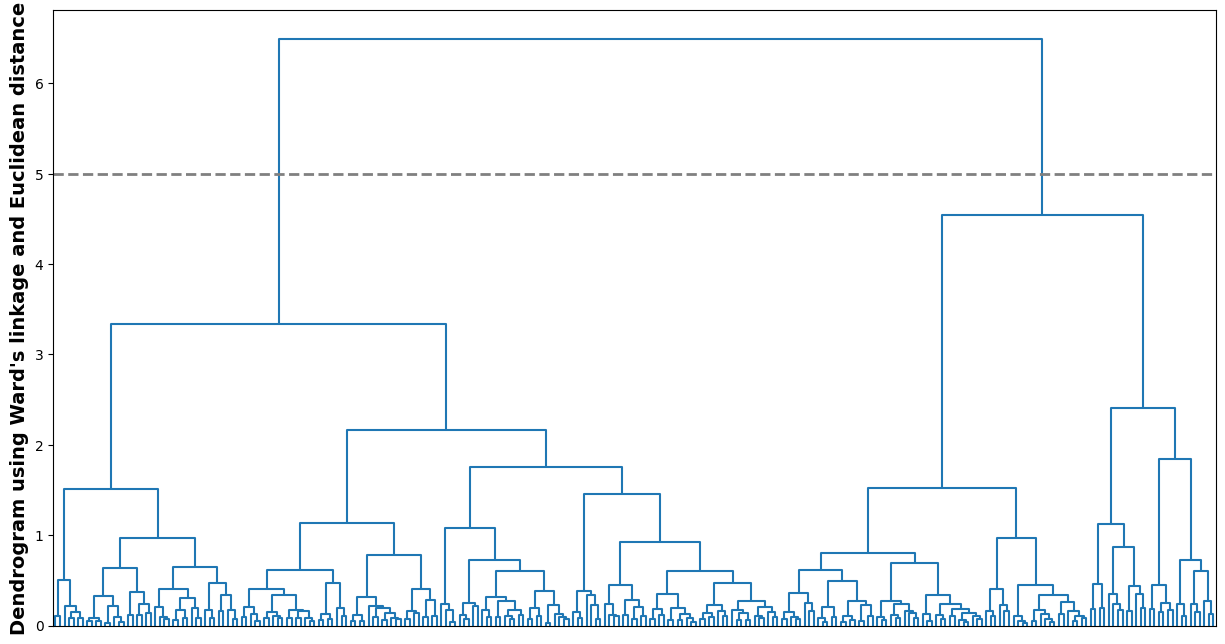

alt.Chart(...)

In [63]:
### GENERATE MACRO CLUSTERS (PHENOTYPES) ###

# Set figure size
plt.figure(figsize = (15, 8)) 

# Define the colour scheme for the dendrogram
#hierarchy.set_link_color_palette(["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728"])
#hierarchy.set_link_color_palette(["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD"])
hierarchy.set_link_color_palette(["#1F77B4", "#FF7F0E", "#6A0D91", "#8FBC8F"])

# Generate and plot the dendrogram
linkage_method = linkage(refvect_df, method ='ward', metric='euclidean')
dendrogram(linkage_method,color_threshold=9, above_threshold_color='black')
plt.tick_params(left = True, right = False , labelleft = True , 
                labelbottom = False, bottom = False) 

plt.axhline(5, color ="grey", linewidth=2,linestyle ="--")
plt.ylabel("Dendrogram using Ward's linkage and Euclidean distance", fontsize = 14, fontweight="bold")

# Save the figure as a PDF
plt.savefig('./figures/V2-dendrogram.pdf', format='pdf')

# Show the plot (optional)
plt.show()

cluster_ea = AgglomerativeClustering(n_clusters=2, linkage='ward')

clusters = cluster_ea.fit_predict(refvect_df)

classMap_clusters = pd.DataFrame({"x1":gtm_model.matX[:,0],
                                        "x2":gtm_model.matX[:,1],
                                        "Participants in Cluster":H.flatten(),
                                        "Cluster":clusters+1}
                                        )

chart_cluster=alt.Chart(classMap_clusters).mark_circle(size = 450).encode(
    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
    size=alt.Size('Participants in Cluster:Q',title = textwrap.wrap('Participants in Cluster',13)),
    color=alt.Color("Cluster:N")
    .scale(range=["#1F77B4", "#FF7F0E", "#6A0D91", "#8FBC8F"])
).configure_view(
    continuousHeight=400,
    continuousWidth=400
)

chart_cluster

In [64]:
chart_cluster.save('./figures/V2-Cluster_member_plot.pdf')

In [65]:
temp_vis = vis_df_updated[['eid']+ list(vis_vars_df["variable_description"].loc[(vis_vars_df["exclude_from_naming"]==0)])]

In [66]:
memb_map_df_all = memb_map_df.merge(temp_vis,left_on='eid',right_on = 'eid')

In [67]:
memb_map_df_all = memb_map_df_all.merge(classMap_clusters[["x1","x2","Cluster"]], how="inner",left_on = ["x1_modes","x2_modes"],right_on=["x1","x2"])

In [68]:
temp_death = pd.read_feather(os.path.join(save_data_path, 'temp_death.feather'))
memb_map_df_all = memb_map_df_all.merge(
    memb_map_df_phecode_metabolomics.loc[:, ["eid"] + list(memb_map_df_phecode_metabolomics.loc[:, "Dementia":"Glaucoma"].columns)],
    left_on='eid',
    right_on='eid'
)
memb_map_df_all = memb_map_df_all.merge(temp_death,left_on = ["eid"],right_on=["eid"])
memb_map_df_all = memb_map_df_all.merge(temp_stroke,left_on = ["eid"],right_on=["eid"])

In [69]:
memb_map_df_all

,eid,lv_stroke_volume_f24102_2_0,lv_myocardial_mass_f24105_2_0,lv_end_diastolic_volume_f24100_2_0,lv_end_systolic_volume_f24101_2_0,lv_ejection_fraction_f24103_2_0,lv_longitudinal_strain_global_f24181_2_0,la_maximum_volume_f24110_2_0,la_ejection_fraction_f24113_2_0,x1_modes,...,ICD 10 - Intracerebral haemorrhage_event_time,ICD 10 - Other nontraumatic intracranial haemorrhage_event,ICD 10 - Other nontraumatic intracranial haemorrhage_origin,ICD 10 - Other nontraumatic intracranial haemorrhage_event_time,ICD 10 - Cerebral infarction_event,ICD 10 - Cerebral infarction_origin,ICD 10 - Cerebral infarction_event_time,"ICD 10 - Stroke, not specified as haemorrhage or infarction_event","ICD 10 - Stroke, not specified as haemorrhage or infarction_origin","ICD 10 - Stroke, not specified as haemorrhage or infarction_event_time"
0,1000103,4.105647,3.116258,4.347953,3.319890,3.890581,2.568604,3.953514,3.982866,-1.000000,...,15.375770,0,0,15.375770,0,0,15.375770,0,0,15.375770
1,1034177,4.156085,3.167347,4.411246,3.386767,3.890442,2.474797,4.125601,4.071076,-1.000000,...,14.477755,0,0,14.477755,0,0,14.477755,0,0,14.477755
2,1054518,4.086238,3.591559,4.280713,3.169522,3.925097,2.612457,4.167175,3.985343,-1.000000,...,15.208761,0,0,15.208761,0,0,15.208761,0,0,15.208761
3,1068636,4.200578,2.905660,4.363099,3.126532,3.976698,2.637349,3.850524,4.073135,-1.000000,...,13.533196,0,0,13.533196,0,0,13.533196,0,0,13.533196
4,1099281,4.259746,3.222768,4.427538,3.176056,3.985337,2.532180,3.877326,3.912973,-1.000000,...,13.691992,0,0,13.691992,0,0,13.691992,0,0,13.691992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36462,5945233,2.452754,2.844380,3.932441,3.920596,2.627657,3.499324,3.797949,3.007904,0.866667,...,14.220397,0,0,14.220397,0,0,14.220397,0,0,14.220397
36463,3476161,2.890216,2.953018,4.195215,4.084122,2.764695,3.580769,4.142149,3.228015,0.866667,...,14.986995,0,0,14.986995,0,0,14.986995,0,0,14.986995
36464,5131732,2.858072,2.924650,4.148628,4.041979,2.783263,3.404211,3.721763,3.187436,0.866667,...,15.370294,0,0,15.370294,0,0,15.370294,0,0,15.370294
36465,5525688,2.828922,3.879834,4.486161,4.417308,2.307513,3.469683,3.965787,3.100341,0.866667,...,15.167693,0,0,15.167693,0,0,15.167693,0,0,15.167693


In [106]:
memb_map_df_all.to_feather("D:/UKBiobank/ML_Stroke/Data/memb_map_df_all.feather")

In [17]:
data_df_impute

,lv_stroke_volume_f24102_2_0,lv_myocardial_mass_f24105_2_0,lv_end_diastolic_volume_f24100_2_0,lv_end_systolic_volume_f24101_2_0,lv_ejection_fraction_f24103_2_0,lv_longitudinal_strain_global_f24181_2_0,la_maximum_volume_f24110_2_0,la_ejection_fraction_f24113_2_0
0,4.105647,3.116258,4.347953,3.319890,3.890581,2.568604,3.953514,3.982866
1,4.449408,3.755187,4.687994,3.528649,3.961034,2.487553,4.679188,3.700005
2,4.280345,3.660580,4.626912,3.712391,3.833525,2.902613,3.902476,3.780228
3,4.234027,4.041863,4.709909,3.971561,3.704937,2.965402,4.075965,3.904529
4,4.412629,4.474404,4.768283,3.834064,3.846612,2.863942,3.817112,3.758875
...,...,...,...,...,...,...,...,...
36462,4.355503,3.286845,4.754581,3.896483,3.796576,2.941134,3.660861,4.087429
36463,4.283752,3.771434,4.665625,3.800848,3.801556,2.881421,4.194813,4.151991
36464,4.156607,3.423719,4.586925,3.814571,3.736021,2.571963,4.072823,3.933767
36465,4.338653,3.861574,4.643429,3.645839,3.881617,3.053794,3.832144,3.965335


In [107]:
### GENERATE PROBABLITY DISTRIBUTION PLOTS ###


i = np.random.randint(len(memb_map_df))


classMap_prob = classMap.copy()
classMap_prob["prob"] = gtm_model.matR[i,:]

prob_map_orig=alt.Chart(classMap_prob).mark_circle(size = 350).encode(
                                                    x=alt.X('x1:Q', axis=alt.Axis(labels=False,title = "")),
                                                    y=alt.Y('x2:Q', axis=alt.Axis(labels=False,title = "")),
                                                    # size=30,
                                                    color=alt.Color('prob:Q',
                                                                    scale=alt.Scale(scheme='viridis', reverse = True) ,
                                                                    title=textwrap.wrap("",20))
                                                ).configure_view(
                                                    continuousHeight=400,
                                                    continuousWidth=400
                                                )

prob_map_orig

alt.Chart(...)

In [108]:
prob_map_orig.save('./figures/v2-Example_patient.pdf')